In [1]:
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, accuracy_score, matthews_corrcoef, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

sys.path.append("../../")

from helpers.split import tag_label_feature_split
from helpers.assess import make_confusion_matrix, make_classification_report

DATASET_FOLDER = "../../datasets/"

In [2]:
# read a data set
dataset="dataset_00_all.pickle"
df = pd.read_pickle(DATASET_FOLDER + dataset)

In [3]:
# get labels, a label encoder and features
_, (y, le), X = tag_label_feature_split(df, label_format="encoded")

In [4]:
# split into train/validation and test datasets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1962
)

In [5]:
# split train/validation into train and test datasets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, shuffle=True, stratify=y_train_val, random_state=1962
)

In [6]:
# standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [7]:
# resample the training set to create balance using SMOTE
smt = SMOTE(random_state=1962)
X_train_res, y_train_res = smt.fit_resample(X_train_scaled, y_train)

In [8]:
# confirm the number of samples of each class
np.unique(y_train_res, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([3205, 3205, 3205, 3205, 3205, 3205, 3205, 3205, 3205, 3205]))

In [9]:
classifier = XGBClassifier(
    learning_rate= .06102, #0.181088,
    n_estimators=425, #419,
    max_depth=9, #3,
    gamma=.1518, #0.174787,
    reg_alpha=7.722, #0.4416,
    use_label_encoder=False,
    tree_method="gpu_hist",
    sampling_method="gradient_based",
    objective="multi:softprob",
    eval_metric=["mlogloss", "auc"], 
    early_stopping_rounds=10,
    seed=1962,
)

eval_set = [(X_train_res, y_train_res), (X_val_scaled, y_val)]
classifier.fit(X_train_res, y_train_res, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=['mlogloss', 'auc'], gamma=0.1518, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.06102, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=9, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=425, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=1962,
              reg_alpha=7.722, ...)

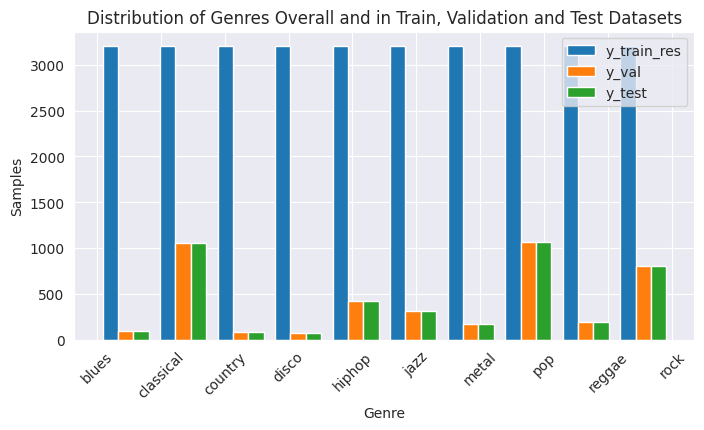

In [10]:
class_count = len(le.classes_)
x_labels = [label[6:] for label in le.inverse_transform(range(class_count))]
plt.figure(figsize=(8,4))
plt.hist([y_train_res, y_val, y_test], label=['y_train_res', 'y_val', 'y_test'])
plt.xticks(range(class_count), x_labels, rotation=45)
plt.title("Distribution of Genres Overall and in Train, Validation and Test Datasets")
plt.xlabel("Genre")
plt.ylabel("Samples")
plt.legend()
plt.show()

In [11]:
classifier_results = classifier.evals_result()

In [12]:
train_results=classifier_results['validation_0']
validation_results=classifier_results['validation_1']
test_predictions=classifier.predict(X_test_scaled)

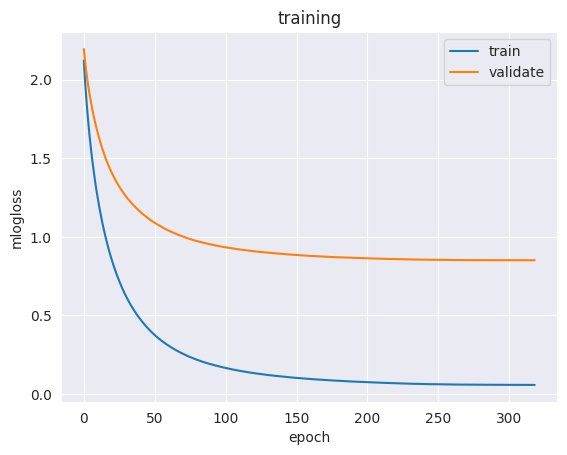

In [13]:
plt.plot(train_results['mlogloss'], label='train')
plt.plot(validation_results['mlogloss'], label='validate')
plt.title('training')
plt.xlabel('epoch')
plt.ylabel('mlogloss')
plt.legend()
plt.show()

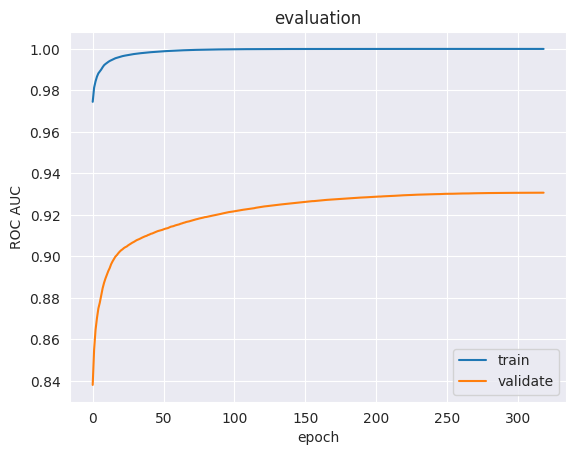

In [14]:
plt.plot(train_results['auc'], label='train')
plt.plot(validation_results['auc'], label='validate')
plt.title('evaluation')
plt.xlabel('epoch')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

In [15]:
matthews_corrcoef(y_test, test_predictions)

0.6602817366470111

In [16]:
balanced_accuracy_score(y_test, test_predictions)

0.5960507731271729

In [17]:
f1_score(y_test, test_predictions, average='macro')

0.6241994012281417

In [18]:
make_classification_report(y_test, test_predictions, label_encoder=le, print_report=True)
pass

                   precision  recall  f1-score  support   mcc
                                                             
      genre_blues       0.55    0.22      0.32       94  0.34
  genre_classical       0.90    0.89      0.89     1055  0.86
    genre_country       0.70    0.37      0.48       82  0.50
      genre_disco       0.54    0.46      0.50       72  0.49
     genre_hiphop       0.74    0.82      0.78      425  0.75
       genre_jazz       0.68    0.58      0.63      311  0.60
      genre_metal       0.70    0.66      0.68      166  0.66
        genre_pop       0.62    0.72      0.66     1069  0.54
     genre_reggae       0.68    0.56      0.62      197  0.60
       genre_rock       0.71    0.69      0.70      800  0.63
                                                             
         accuracy                         0.72     4271  0.66
        macro avg       0.68    0.60      0.62     4271      
     weighted avg       0.72    0.72      0.72     4271      
        

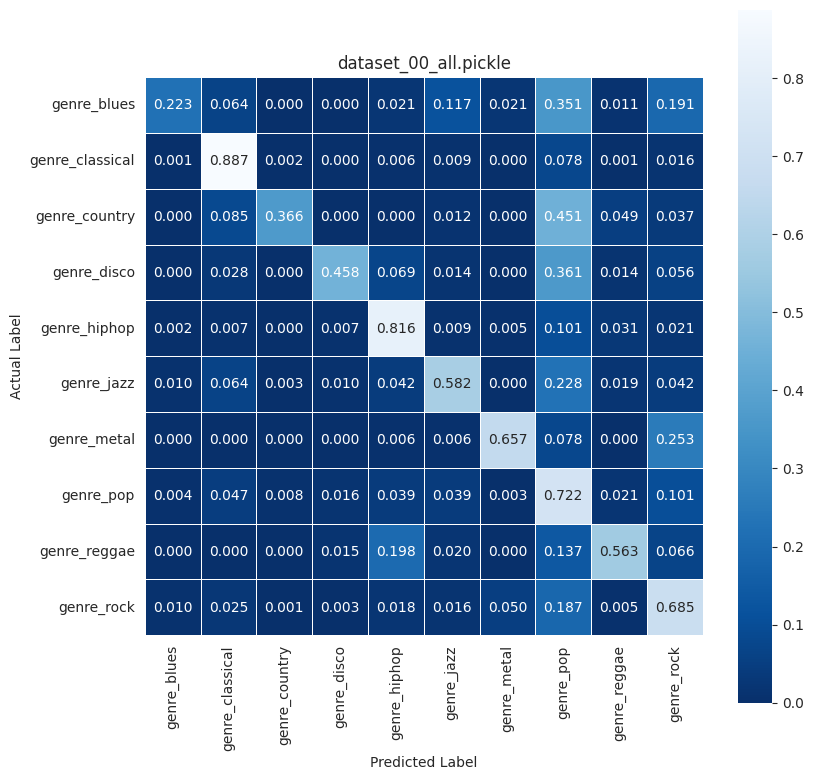

In [19]:
make_confusion_matrix(y_test, test_predictions, label_encoder=le, title=dataset)
pass